In [31]:
import datetime
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import numpy as np
import pandas as pd
import parser
#from mpl_toolkits.basemap import Basemap

ImportError: No module named basemap

In [25]:
#It might be different for all users
path = '/Users/admin/project_data_141'

In [3]:
def read_data(path, year):
    """
    reads csv data and returns 4 data frames for the given year
    input: path
    output: 4 data frames (station, status, trip, and weather)
    """
    path = path + '/' + str(year) + '/'
    station = pd.read_csv(path + 'station.csv')
    status = pd.read_csv(path + 'status.csv')
    trip = pd.read_csv(path + 'trip.csv')
    weather = pd.read_csv(path + 'weather.csv')
    
    return station, status, trip, weather

In [4]:
station, status, trip, weather = read_data(path, 2016)

In [10]:
station.head()

,station_id,name,lat,long,dockcount,landmark,installation
0,2.0,San Jose Diridon Caltrain Station,37.329732,-121.901782,27.0,San Jose,8/6/2013
1,3.0,San Jose Civic Center,37.330698,-121.888979,15.0,San Jose,8/5/2013
2,4.0,Santa Clara at Almaden,37.333988,-121.894902,11.0,San Jose,8/6/2013
3,5.0,Adobe on Almaden,37.331415,-121.893200,19.0,San Jose,8/5/2013
4,6.0,San Pedro Square,37.336721,-121.894074,15.0,San Jose,8/7/2013


In [6]:
print station.shape, status.shape, trip.shape, weather.shape

(992, 7) (35517185, 4) (313689, 11) (1830, 24)


In [11]:
status.head(3)

,station_id,bikes_available,docks_available,time
0,2,18,9,9/1/2015 00:00:02
1,2,18,9,9/1/2015 00:01:02
2,2,18,9,9/1/2015 00:02:02


In [24]:
trip.sort_values(by='Duration', ascending = False).head()
#Duration is in seconds, not minutes

,Trip ID,Duration,Start Date,Start Station,Start Terminal,End Date,End Station,End Terminal,Bike #,Subscriber Type,Zip Code
263728,1270563,86325,7/9/2016 16:30,2nd at Townsend,61,7/10/2016 16:28,Washington at Kearny,46,514,Customer,92657
8068,924015,86228,9/9/2015 10:23,Howard at 2nd,63,9/10/2015 10:20,Howard at 2nd,63,362,Customer,NaN
263736,1270571,86110,7/9/2016 16:33,2nd at Townsend,61,7/10/2016 16:28,Washington at Kearny,46,617,Customer,93704
263738,1270573,86001,7/9/2016 16:35,2nd at Townsend,61,7/10/2016 16:28,Washington at Kearny,46,280,Customer,nil
192641,1173890,85900,4/22/2016 19:11,San Francisco Caltrain (Townsend at 4th),70,4/23/2016 19:03,Grant Avenue at Columbus Avenue,73,398,Subscriber,94133


In [14]:
for name in list(weather.columns):
    print name

PDT
Max TemperatureF
Mean TemperatureF
Min TemperatureF
Max Dew PointF
MeanDew PointF
Min DewpointF
Max Humidity
 Mean Humidity
 Min Humidity
 Max Sea Level PressureIn
 Mean Sea Level PressureIn
 Min Sea Level PressureIn
 Max VisibilityMiles
 Mean VisibilityMiles
 Min VisibilityMiles
 Max Wind SpeedMPH
 Mean Wind SpeedMPH
 Max Gust SpeedMPH
PrecipitationIn
 CloudCover
 Events
 WindDirDegrees
ZIP


In [15]:
datetime.datetime.strptime("2017/3/1", "%Y/%m/%d")
def convert(date):
    #return parser.parse(date).strftime('%Y%m%d')
    return matplotlib.dates.datestr2num(date)

In [16]:
dates = weather['PDT'].apply(convert)

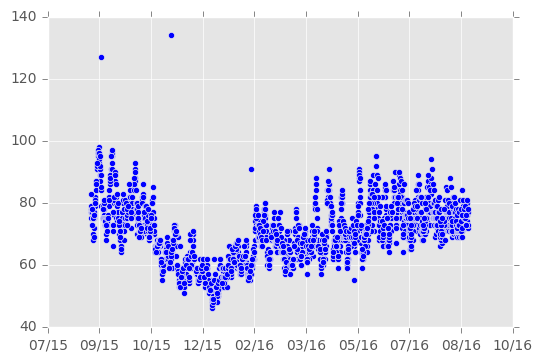

In [20]:
plt.scatter(dates, weather['Max TemperatureF'])
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%y'))
plt.show()